<a href="https://colab.research.google.com/github/siva-sankar-a/eva_final_project/blob/master/EVA_S15_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchviz
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
%load_ext autoreload
%autoreload 2

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-26qlbnno
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-26qlbnno
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65038 sha256=58c9b12b153a64e81a3fe93e16471e1c67f26a46b01a2d5fc04fd6710e3d262d
  Stored in directory: /tmp/pip-ephem-wheel-cache-asbiyp3x/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [0]:
import subprocess
import urllib
import cv2
import os
import glob
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
import torchvision
from torchsummary import summary 
from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_url, download_and_extract_archive

from albumentations import Compose, Rotate, HorizontalFlip, Normalize, RandomCrop, Cutout, PadIfNeeded, Lambda
from albumentations.pytorch import ToTensor

from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
import torchvision.models as models

from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau

import tensorflow as tf

from tqdm import tqdm

from multiprocessing import Process
from zipfile import ZipFile, ZIP_DEFLATED

In [0]:
class FgBgDataset(Dataset):
  """
  Custom class to load foreground background image dataset
  """
  def __init__(self, no_of_parts=10, 
               fg_bg_train_transform=None, 
               bg_train_transform=None, 
               fg_bg_test_transform=None, 
               bg_test_transform=None,
               target_transform=None, 
               mask_transform = None,
               depth_transform = None,
               **kwargs):
    """
    Constructor for foreground background image dataset
    """
    super().__init__(**kwargs)

    self.ROOT_URL = 'https://eva-final-project-dataset.s3-ap-southeast-2.amazonaws.com/'
    self.COMPRESSED_DIR = './compressed'
    self.DATASET_DIR = './dataset'
    self.DATASET_INFO_FILE = 'dataset_info.csv'
    self.DATASET_FILE_PREFIX = 'dataset_'

    self.no_of_parts = no_of_parts
    self.dataset_info_file_path = os.path.join(self.DATASET_DIR, self.DATASET_INFO_FILE)

    self.download_dataset()

    self.df = pd.read_csv(self.dataset_info_file_path)

    self.train = True
    self.fg_bg_train_transform = fg_bg_train_transform 
    self.bg_train_transform = bg_train_transform 
    self.fg_bg_test_transform = fg_bg_test_transform 
    self.bg_test_transform = bg_test_transform

    self.mask_transform = mask_transform
    self.depth_transform = depth_transform

  def download_dataset(self):
    if not os.path.exists(self.DATASET_DIR):
      print('Downloading dataset..')
      os.mkdir(self.DATASET_DIR)
      if not os.path.exists(self.COMPRESSED_DIR):
        os.mkdir(self.COMPRESSED_DIR)

      dataset_info_url = urllib.parse.urljoin(self.ROOT_URL, self.DATASET_INFO_FILE)
      download_url(dataset_info_url, self.DATASET_DIR, self.DATASET_INFO_FILE)
      dataset_info_url = urllib.parse.urljoin(self.ROOT_URL, self.DATASET_INFO_FILE)

      processes = [Process(target=self.download_and_extract_part, args=(part_idx,)) for part_idx in range(self.no_of_parts)]
      processes.append(Process(target=self.download_and_extract_bg))
      for process in processes:
        process.start()
      for process in processes:
        process.join()
    else:
      print('Dataset found!')

  def download_and_extract_part(self, part):
    dataset_part_path = f'{self.DATASET_FILE_PREFIX}{part}.zip'
    dataset_part_url = urllib.parse.urljoin(self.ROOT_URL, dataset_part_path)
    download_and_extract_archive(dataset_part_url, self.COMPRESSED_DIR, self.DATASET_DIR)
  
  def download_and_extract_bg(self):
    bg_path = f'bg_cropped.zip'
    bg_url = urllib.parse.urljoin(self.ROOT_URL, bg_path)
    download_and_extract_archive(bg_url, self.COMPRESSED_DIR, self.DATASET_DIR)

  def __len__(self):
      return len(self.df)

  def set_train(self):
      self.train = True

  def set_eval(self):
      self.train = False

  def __getitem__(self, index):
    if torch.is_tensor(index):
      index = index.tolist()

    fg_bg_path = os.path.join(self.DATASET_DIR, self.df['fg_bg_paths'].iloc[index])
    bg_path = os.path.join(self.DATASET_DIR, self.df['selected_bg_paths'].iloc[index])
    mask_path = os.path.join(self.DATASET_DIR, self.df['mask_paths'].iloc[index])
    depth_map_path = os.path.join(self.DATASET_DIR, self.df['depth_map_paths'].iloc[index])
    
    fg_bg_img = cv2.imread(fg_bg_path)
    fg_bg_img = cv2.cvtColor(fg_bg_img, cv2.COLOR_BGR2RGB)

    bg_img = cv2.imread(bg_path)
    bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)

    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    depth_img = cv2.imread(depth_map_path, cv2.IMREAD_GRAYSCALE)

    if self.train:
      if self.fg_bg_train_transform:
        augmented = self.fg_bg_train_transform(image=fg_bg_img)
        fg_bg_img = augmented['image']
      if self.bg_train_transform:
        augmented = self.bg_train_transform(image=bg_img)
        bg_img = augmented['image']

    else:
      if self.fg_bg_test_transform:
        augmented = self.fg_bg_test_transform(image=fg_bg_img)
        fg_bg_img = augmented['image']
      if self.bg_test_transform:
        augmented = self.bg_test_transform(image=bg_img)
        bg_img = augmented['image']

    if self.depth_transform is not None:
        augmented = self.depth_transform(image=depth_img)
        depth_img = augmented['image']

    if self.mask_transform is not None:
        augmented = self.mask_transform(image=mask_img)
        mask_img = augmented['image']

    return { 'fg_bg': fg_bg_img, 'mask': mask_img, 'depth': depth_img, 'bg': bg_img }

In [0]:
def padded_random_crop_fg_bg(x, **kwargs):
    x = PadIfNeeded(min_height=72, min_width=72, border_mode=4,
                    value=None, mask_value=None, always_apply=True).apply(x)
    x = RandomCrop(height=64, width=64, always_apply=True).apply(x)
    return x

In [0]:
fg_bg_train_transform = Compose([Normalize(
                                    mean=[0.4561, 0.3984, 0.3620],
                                    std=[0.2866, 0.2640, 0.2774],
                                ),
                                ToTensor()
                            ])
bg_train_transform = Compose([Normalize(
                                    mean=[0.5869, 0.5174, 0.4732],
                                    std=[0.2560, 0.2398, 0.2781],
                                ),
                                ToTensor()
                            ])
mask_transform = Compose([Normalize(
                                    mean=[0.0903],
                                    std=[0.2781],
                                ),
                          ToTensor()])
depth_transform = Compose([Normalize(
                                    mean=[0.6289],
                                    std=[0.2238],
                                ),
                           ToTensor()])
fg_bg_test_transform = Compose([ToTensor()])
bg_test_transform = Compose([ToTensor()])

In [6]:
dataset = FgBgDataset(fg_bg_test_transform=fg_bg_test_transform, bg_test_transform=bg_test_transform, mask_transform=mask_transform, depth_transform=depth_transform)
batch_size = 8
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=batch_size)
data_loader = torch.utils.data.DataLoader(dataset, **dataloader_args, drop_last=True)

Dataset found!


In [0]:
dataset.set_eval()

In [0]:
tqdm._instances.clear()

Finding dataset mean and standard deviation

In [14]:
pbar = tqdm(data_loader)
dataset_len = len(data_loader.dataset)

fg_bg_mean = torch.zeros(3).to(device)
bg_mean = torch.zeros(3).to(device)
mask_mean = torch.zeros(1).to(device)
depth_mean = torch.zeros(1).to(device)

fg_bg_var = torch.zeros(3).to(device)
bg_var = torch.zeros(3).to(device)
mask_var = torch.zeros(1).to(device)
depth_var = torch.zeros(1).to(device)

for batch_idx, sample_batch in enumerate(pbar):
    fg_bg_images = sample_batch['fg_bg']
    bg_images = sample_batch['bg']
    mask_images = sample_batch['mask']
    depth_images = sample_batch['depth']

    fg_bg_images = fg_bg_images.to(device)
    bg_images = bg_images.to(device)
    mask_images = mask_images.to(device)
    depth_images = depth_images.to(device)

    fg_bg_mean += fg_bg_images.mean([0, 2, 3])
    bg_mean += bg_images.mean([0, 2, 3])
    mask_mean += mask_images.mean()
    depth_mean += depth_images.mean()

    fg_bg_var += fg_bg_images.std([0, 2, 3]) ** 2
    bg_var += bg_images.std([0, 2, 3]) ** 2
    mask_var += mask_images.std() ** 2
    depth_var += depth_images.std() ** 2

100%|██████████| 2500/2500 [55:27<00:00,  1.33s/it]


In [0]:
n_batches = dataset_len / batch_size

In [28]:
fg_bg_mean/n_batches, bg_mean/n_batches, mask_mean/n_batches, depth_mean/n_batches

(tensor([0.4561, 0.3984, 0.3620], device='cuda:0'),
 tensor([0.5869, 0.5174, 0.4732], device='cuda:0'),
 tensor([0.0903], device='cuda:0'),
 tensor([0.6289], device='cuda:0'))

In [22]:
torch.sqrt(fg_bg_var/n_batches), torch.sqrt(bg_var/n_batches), torch.sqrt(mask_var/n_batches), torch.sqrt(depth_var/n_batches)

(tensor([0.2866, 0.2640, 0.2774], device='cuda:0'),
 tensor([0.2560, 0.2398, 0.2781], device='cuda:0'),
 tensor([0.2781], device='cuda:0'),
 tensor([0.2238], device='cuda:0'))

In [0]:
data_iter = iter(data_loader)
batch = next(data_iter)

fg_bg_images = batch['fg_bg']
bg_images = batch['bg']
mask_images = batch['mask']
depth_images = batch['depth']

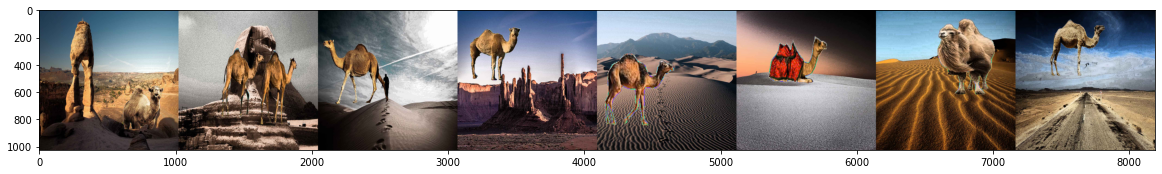

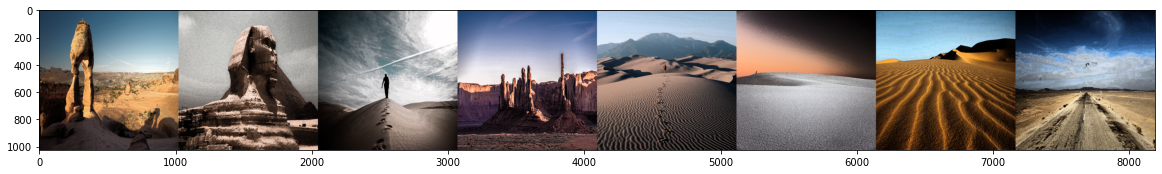

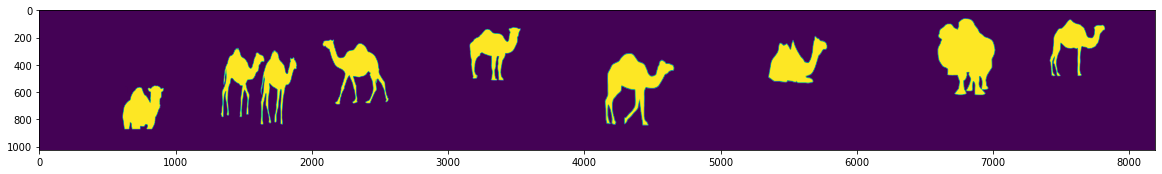

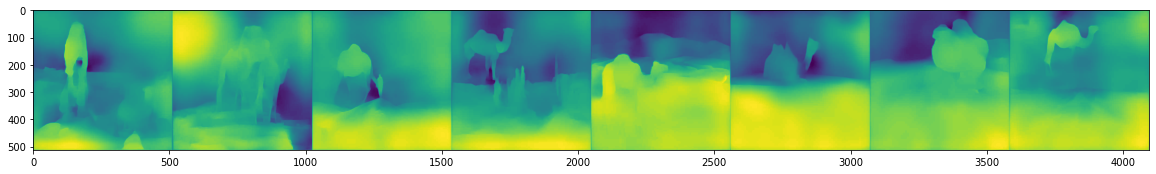

In [11]:
plt.figure(figsize=(20, 5))
plt.imshow(np.hstack(fg_bg_images.permute(0, 2, 3, 1)), cmap='jet')

plt.figure(figsize=(20, 5))
plt.imshow(np.hstack(bg_images.permute(0, 2, 3, 1)), cmap='jet')

plt.figure(figsize=(20, 5))
plt.imshow(np.hstack(mask_images.permute(0, 2, 1)))

plt.figure(figsize=(20, 5))
plt.imshow(np.hstack(depth_images.permute(0, 2, 1)))